# Unstructured Data Analytics HW3

Name: Manikandan Palaniappan

Andrew ID: mpalania

Reminder: you should not be sharing code.

### Instructions

1. Fill in your name and Andrew ID above.
2. Fill in the code/text blocks to answer each question.
3. Do *not* change any of the existing code provided.
4. Run the entire notebook *before* submitting it on Canvas to make sure that the code actually runs without errors. (**Important**: Any code cells that you have entered code for but did not actually execute will be disregarded, so please be sure to actually run your code first and make sure it runs without errors! We may re-run a subset of your code for grading purposes).
5. Be careful about where you save data for use with this Jupyter notebook (more details on this later).
6. You are encouraged to seek assistance from ChatGPT in developing your code.

### **Part 1 (55 points)**: Time Series Data Analysis

The Air Quality UCI dataset provides detailed recordings from a gas multisensor device deployed in a highly polluted area of an Italian city to monitor air quality. This dataset captures hourly averages of gas concentrations and sensor responses over the span of one year, from March 2004 to February 2005, making it one of the longest publicly available datasets of its kind. It includes data from five metal oxide chemical sensors on key pollutants such as CO, Non Methanic Hydrocarbons, Benzene, NOx, and NO2, with ground truth provided by a certified reference analyzer. The dataset, comprising 9358 instances, also highlights challenges like cross-sensitivities and sensor drifts that can impact the accuracy of pollution estimation.

##### Load and Preprocess Air Quality Data

In [16]:
import pandas as pd

# Load data from local file
from google.colab import files
#Select the zip file and upload it to the root dirctory on Colab.
uploaded = files.upload()

# Read the data
data = pd.read_csv("AirQualityUCI.csv", delimiter=';').loc[:, ['Date', 'Time', 'NOx(GT)']]
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
data.drop(columns=['Date', 'Time'], inplace=True)
data.dropna(inplace=True)
# Display the first few rows of the dataset to understand its structure
data.head()

Saving AirQualityUCI.csv to AirQualityUCI (1).csv


,NOx(GT),DateTime
0,166.0,2004-03-10 18:00:00
1,103.0,2004-03-10 19:00:00
2,131.0,2004-03-10 20:00:00
3,172.0,2004-03-10 21:00:00
4,131.0,2004-03-10 22:00:00


##### **Part 1.1 (10 points)**: Data Visualization

Please visualize the time series `NOx(GT)`. What prominent feature(s) can you observe from the time series?

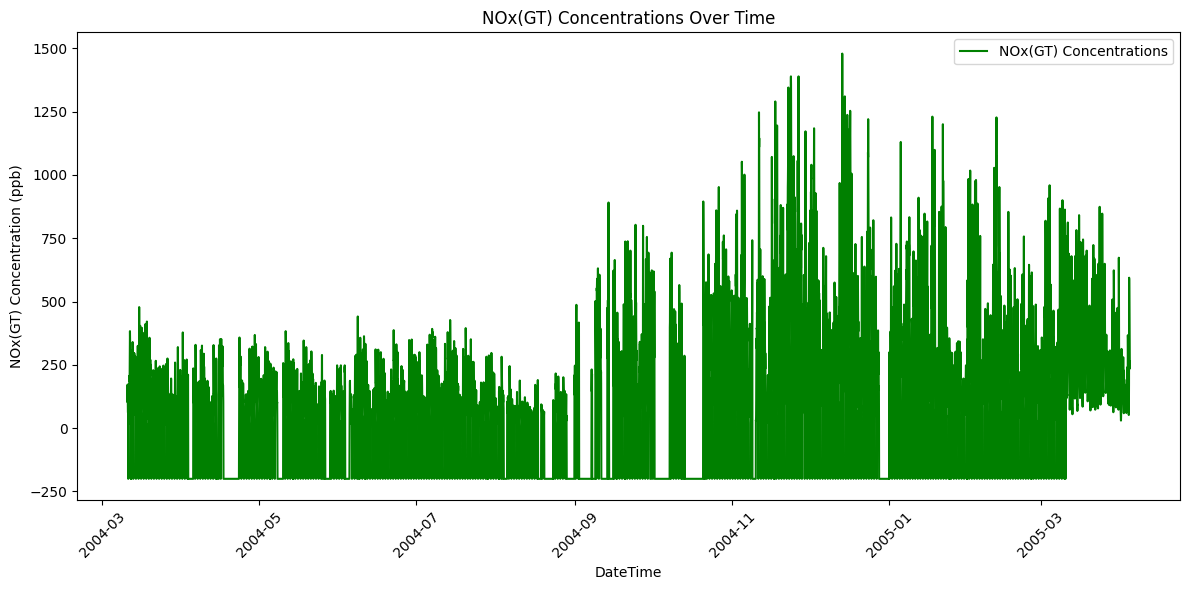

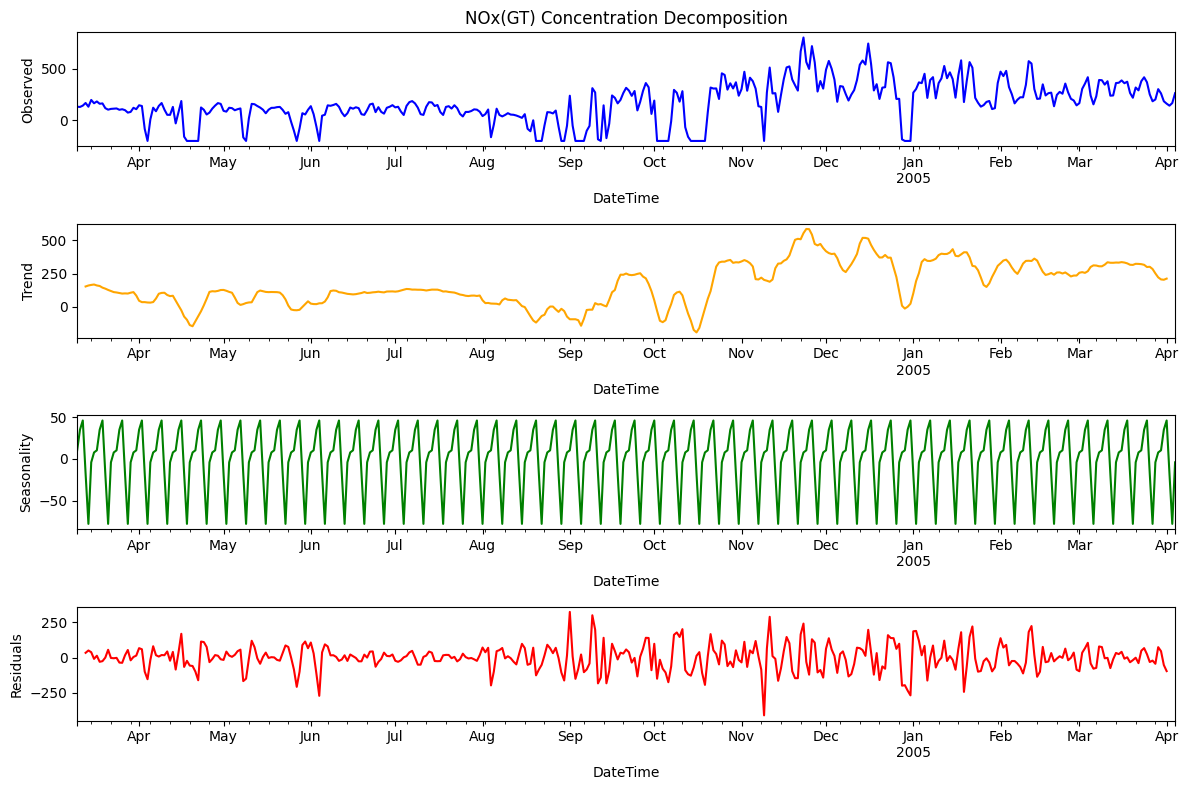

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Your code here (5 points)
# Plotting NOx(GT) concentrations over time
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['NOx(GT)'], label='NOx(GT) Concentrations', color='green')
plt.title('NOx(GT) Concentrations Over Time')
plt.xlabel('DateTime')
plt.ylabel('NOx(GT) Concentration (ppb)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Writing out the decomposition logic for trend, seasonality and residuals

# Resample the data to daily averages to simplify the analysis
data_resampled = data.set_index('DateTime').resample('D').mean().dropna()

# Decompose the time series to analyze trend, seasonality, and residuals
decomposition = seasonal_decompose(data_resampled['NOx(GT)'], model='additive')

# Plot the decomposed time series components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], legend=False, color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title('NOx(GT) Concentration Decomposition')

decomposition.trend.plot(ax=axes[1], legend=False, color='orange')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False, color='green')
axes[2].set_ylabel('Seasonality')

decomposition.resid.plot(ax=axes[3], legend=False, color='red')
axes[3].set_ylabel('Residuals')

plt.tight_layout()
plt.show()


**Your discussion here (5 points)**

1) The concentrations of NOx(GT) concentrations fluctuate over time with periodic increases and decreases without any clear long-term upward or downward trend.

2) There is a repeatable pattern with in a year, indicating the presence of seasonality in the data

3)The residuals seem to show some volatility, and the infrequent spikes might need to be investigated for any outliers

4)However, There are not many large, unexplained anomalies in the data based on the graph

##### Preparing for Time-Series Prediction

Code in the following cell prepares a dataset for time series forecasting by creating lagged features of NOx concentrations, cleaning the data, and splitting it into training and test sets.

In [18]:
num_lags = 80  # Number of lagged observations to use as features

# Data Preparation focusing on 'NOx(GT)' column
nox_data = data['NOx(GT)'].dropna().reset_index(drop=True)  # Remove missing values from NOx(GT) and reset the index

# Resetting the DataFrame for lagged data
nox_data_lagged = pd.DataFrame()  # Initialize an empty DataFrame for lagged features

# Create lagged features up to num_lags
for i in range(1, num_lags + 1):
    nox_data_lagged[f'NOx_lag_{i}'] = nox_data.shift(i)  # Create a new column for each lag, shifting the NOx data by i periods

# Include the original NOx data as the target variable
nox_data_lagged['NOx'] = nox_data  # Add the original NOx data as a column to be used as the target variable for prediction

# Drop rows with NaN values due to lagging
nox_data_lagged.dropna(inplace=True)  # Remove the first num_lags rows which now contain NaN values because of the shifting

# Prepare feature and target datasets
X = nox_data_lagged.drop('NOx', axis=1)  # Features are all the lagged NOx columns
y = nox_data_lagged['NOx'].values  # Target variable is the original NOx column

# Splitting the dataset into training and test sets
X_train = X[:int(len(nox_data_lagged) * 0.8)]  # 80% of data for training
y_train = y[:int(len(nox_data_lagged) * 0.8)]
X_test = X[int(len(nox_data_lagged) * 0.8):]  # Remaining 20% for testing
y_test = y[int(len(nox_data_lagged) * 0.8):]

# Aligning DateTime for training and test sets
data_datetime_aligned = data['DateTime'].dropna().reset_index(drop=True)  # Align DateTime column by removing NaN values and resetting index
train_datetime = data_datetime_aligned.loc[X_train.index].values  # Extract DateTime values corresponding to the training set
test_datetime = data_datetime_aligned.loc[X_test.index].values  # Extract DateTime values corresponding to the test set

print(f'Shape of training input: {X_train.shape}, training output: {y_train.shape}')
print(f'Example of training input: {X_train.iloc[0].values} -> output: {y_train[0]}')
print('That is, we predict the NOx concentration at time t using the NOx concentration at times t-1, t-2, ..., t-80.')
print(f'Shape of test input: {X_test.shape}, test output: {y_test.shape}')

Shape of training input: (7421, 80), training output: (7421,)
Example of training input: [ 174.  190.  172.  214.  283.  279.  277.  227.  148.  138.  119.  118.
  153.  239.  296.  250.  295.  256.  139.   53.   62.  109. -200.   83.
  139.  193.  300.  253.  274.  340.  202.  206.  150.  178.  190.  163.
  160.  143.  216.  187. -200.  307.  109.   56.   30.   21. -200.   82.
  133.  122.   47.   94.  240.  351.  383.  281.  243.  193.  184.  207.
  146.  104.   95.  112.  129.  174.   98.   34.   16.   21. -200.   45.
   62.   62.   89.  131.  172.  131.  103.  166.] -> output: 128.0
That is, we predict the NOx concentration at time t using the NOx concentration at times t-1, t-2, ..., t-80.
Shape of test input: (1856, 80), test output: (1856,)


##### **Part 1.2 (10 points)**: Auto-Regressive Model

**Part 1.2.1 (5 points)**: Please use an auto-regressive model to predict the NOx level of the next period given past NOx levels.

Your model should train on `X_train` and `y_train`. Please report the mean squared error (MSE) on the test set. Save your test-set predictions to `y_pred`.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Your code here (5 points)
# Training the auto-regressive model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the NOx level for the test set
y_pred = model.predict(X_test)

# Calculating the MSE on the test set
mse = mean_squared_error(y_test, y_pred)
print("The mean squared error of the model is:\t",mse)

The mean squared error of the model is:	 11117.398521236573


**Part 1.2.2 (5 points)**: Please implement the `visualize` method. It should visualize the time series in the test set and the predicted time series _on the same plot_. Make sure to adjust the line color/style/width/etc so that it's easy to compare the two series.

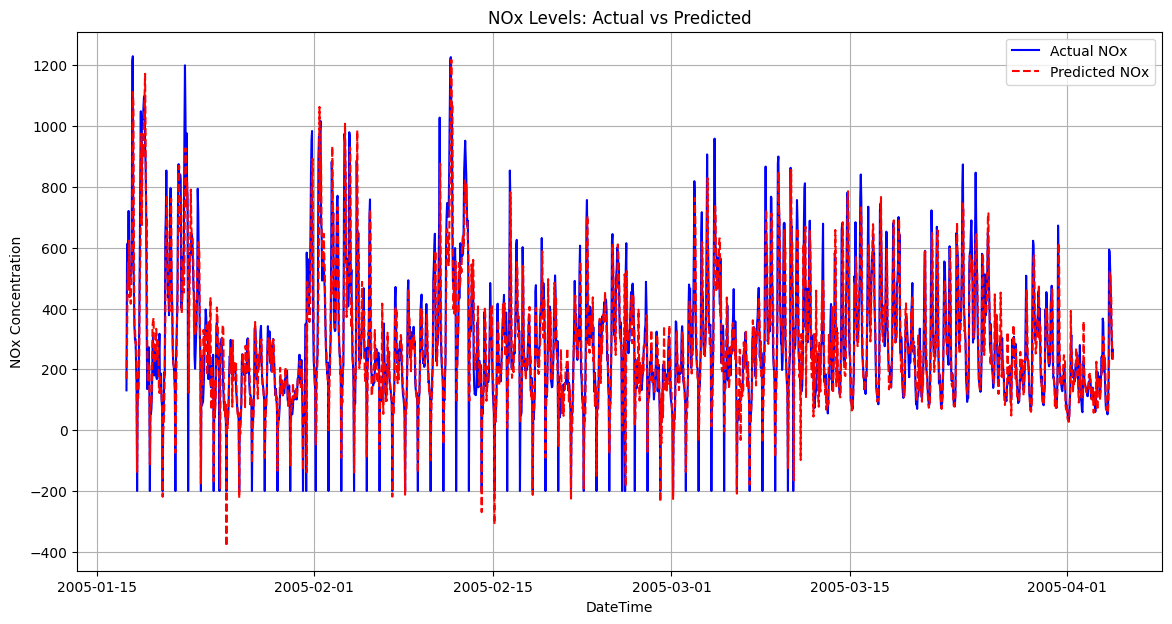

In [20]:
def visualize(y_test, y_pred, test_datetime):
    # Plotting the test set and the predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(test_datetime, y_test, label='Actual NOx', color='blue', linewidth=1.5, linestyle='-')
    plt.plot(test_datetime, y_pred, label='Predicted NOx', color='red', linewidth=1.5, linestyle='--')

    plt.title('NOx Levels: Actual vs Predicted')
    plt.xlabel('DateTime')
    plt.ylabel('NOx Concentration')
    plt.legend()
    plt.grid(True)

    plt.show()


visualize(y_test, y_pred, test_datetime)

### Recurrent Neural Network Modeling

##### **Part 1.3 (35 points)**: Using RNN to model time series data

Code in the following cell prepares the data for RNN training. It reshapes the data and applies min-max scaling.

_Note that you can run the following cell only once. If you need to rerun it, you'll need to rerun the cells above first._

In [21]:
from sklearn.preprocessing import MinMaxScaler


X_train = X_train.values.reshape(*X_train.shape, 1)
y_train = y_train.reshape(*y_train.shape, 1)
X_test = X_test.values.reshape(*X_test.shape, 1)
y_test = y_test.reshape(*y_test.shape, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(*X_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(*X_test.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

print(f'Shape of training input: {X_train_scaled.shape}, training output: {y_train_scaled.shape}')
print(f'Example of data before scaling: {X_train[0, :5]} -> {y_train[0]}')
print(f'Example of data after scaling: {X_train_scaled[0, :5]} -> {y_train_scaled[0]}')

Shape of training input: (7421, 80, 1), training output: (7421, 1)
Example of data before scaling: [[174.]
 [190.]
 [172.]
 [214.]
 [283.]] -> [128.]
Example of data after scaling: [[0.22275164]
 [0.23228112]
 [0.22156045]
 [0.24657534]
 [0.28767123]] -> [0.19535438]


##### RNN Model

_Note: `hw3_utils` requires the following packages:_
```
numpy torch torchvision tqdm scikit-learn
```

To work with RNN models, it is usually necessary to use a deep learning library such as `torch`. For the purpose of this homework, in `hw3_utils`, the class `RNNRegressor` has been implemented for you. It wraps a customizable `torch` module into a `sklearn` regressor. You are encouraged to take a look at the implementation if you are interested.

You can initiate an `RNNRegressor` with the following arguments:
- `input_dim`: Specifies the number of input features for the model.
- `hidden_dim`: Determines the size of the hidden layers within the RNN.
- `output_dim`: The size of the output layer. By default, it is set to 1, indicating a single predicted value per input.
- `num_layers`: The number of recurrent layers in the network. Defaults to 1, indicating a single RNN layer.
- `sequence_length`: The length of the input sequences that the model will process. This parameter is crucial for defining how much of the past information the model will consider for making predictions.
- `learning_rate`: Controls the size of the steps the optimizer takes while searching for the model's minimum loss. A smaller learning rate means the model will adjust its weights more gradually during training.
- `num_epochs`: The number of times the entire dataset will be passed forward and backward through the RNN. This parameter defines the length of the training process.
- `batch_size`: The number of samples that will be propagated through the network in one forward/backward pass. It defines how many examples you look at before making a weight update.

**Part 1.3.1 (10 points)**: Please use `RNNRegressor` to fit the **unscaled** training data (`X_train`, `y_train`). Please report the mean squared error (MSE) on the test set and visualize your predictions using the `visualize` method you implemented. For this part, don't worry about tuning the hyperparameters. Your model's performance on the unscaled data is likely pretty bad.

In [24]:
#Upload the hw3_utils file
#Load data from local file
from google.colab import files
#Select the zip file and upload it to the root dirctory on Colab.
uploaded = files.upload()

Saving hw3_utils.py to hw3_utils (3).py


The mean squared error of the model is:	 132004.53116295216


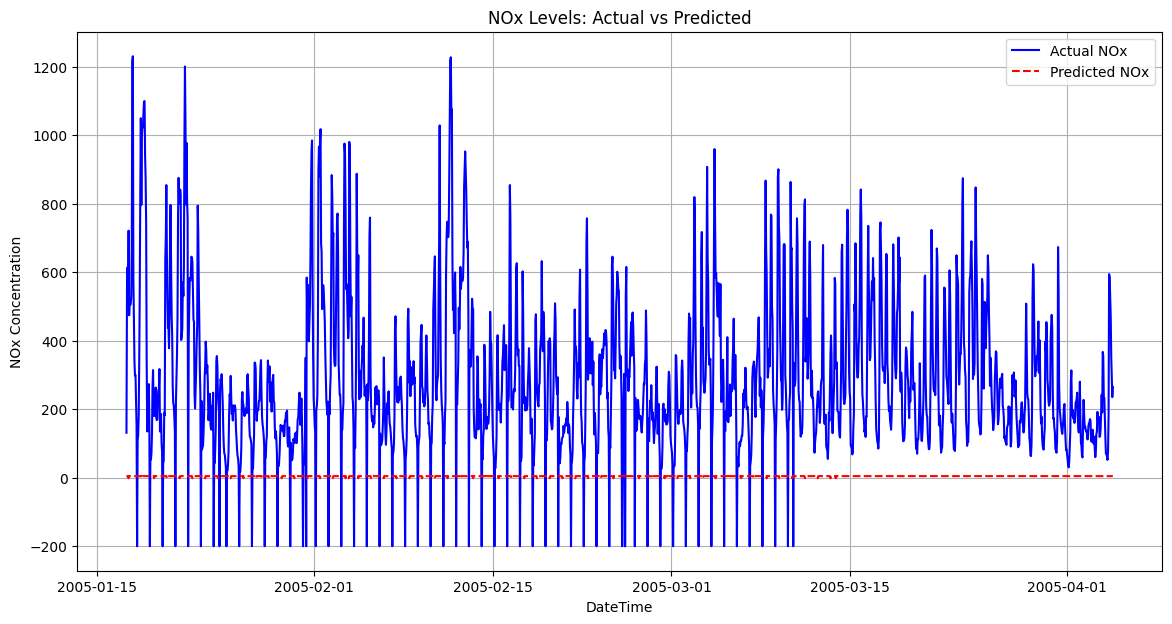

In [25]:
from hw3_utils import RNNRegressor

input_dim = 1
hidden_dim = 1

# Your code here
model = RNNRegressor(input_dim, hidden_dim)
model.fit(X_train, y_train)

# Predicting the NOx level for the test set
y_pred = model.predict(X_test)

# Calculating the MSE on the test set
mse = mean_squared_error(y_test, y_pred)

print("The mean squared error of the model is:\t",mse)

visualize(y_test, y_pred, test_datetime)

**Part 1.3.2 (10 points)**: Now use `RNNRegressor` to fit the **scaled** training data (`X_train_scaled`, `y_train_scaled`). Please report the mean squared error (MSE) on the test set and visualize your **unscaled** predictions using the `visualize` method you implemented.

_Hint: Since your model is trained on the **scaled** data, it should take the scaled data as input for prediction. Its predictions are also scaled. To convert scaled predictions back to unscaled, use `scaler.inverse_transform`._

The mean squared error of the model is:	 70194.19659828985


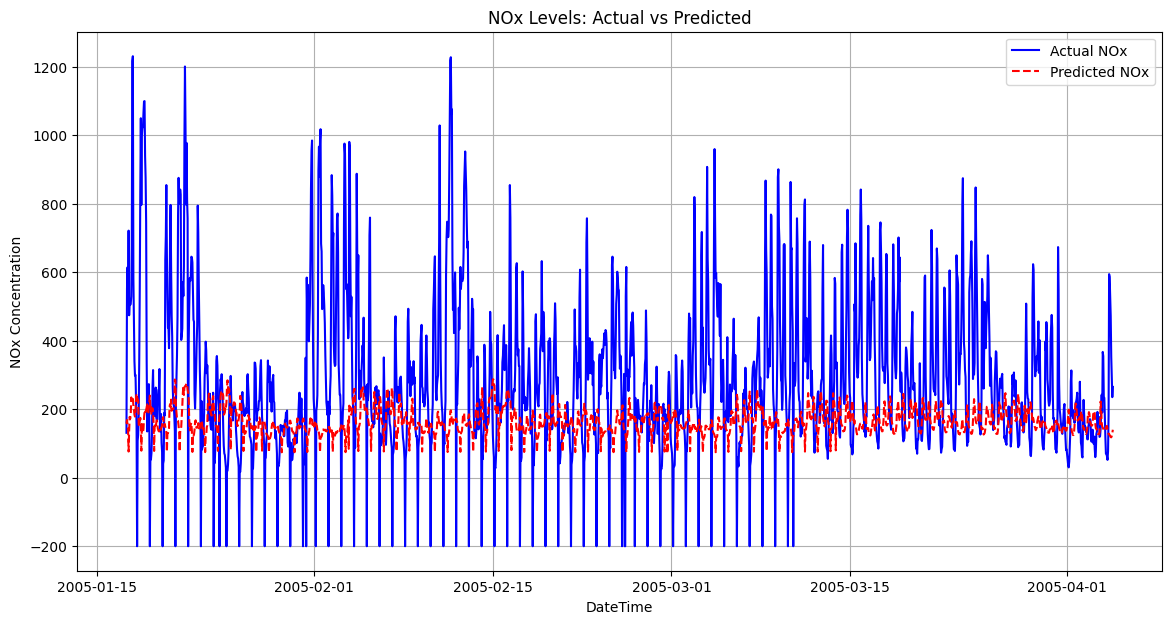

In [26]:
# Your code here

input_dim = 1
hidden_dim = 1

# Your code here
model = RNNRegressor(input_dim, hidden_dim)
model.fit(X_train_scaled, y_train_scaled)

# Predicting the NOx level for the test set
y_pred = scaler.inverse_transform(model.predict(X_test_scaled))

# Calculating the MSE on the test set
mse = mean_squared_error(y_test, y_pred)

print("The mean squared error of the model is:\t",mse)

visualize(y_test, y_pred, test_datetime)

**Part 1.3.3.1 (10 points)**: Please try to improve your model's performance in **Part 1.3.2** by tuning the hyperparameters. You may copy your code in the previous cell and use the following cell for experimentation.

Briefly discuss **what** you did and **how** your changes affected the predictions.

_This exercise is meant to help you get a flavor of hyperparameter tuning. There is no performance threshold for you to get points. Don't worry too much if you can't seem to get it to work well._

The mean squared error of the model is:	 15854.329485920784


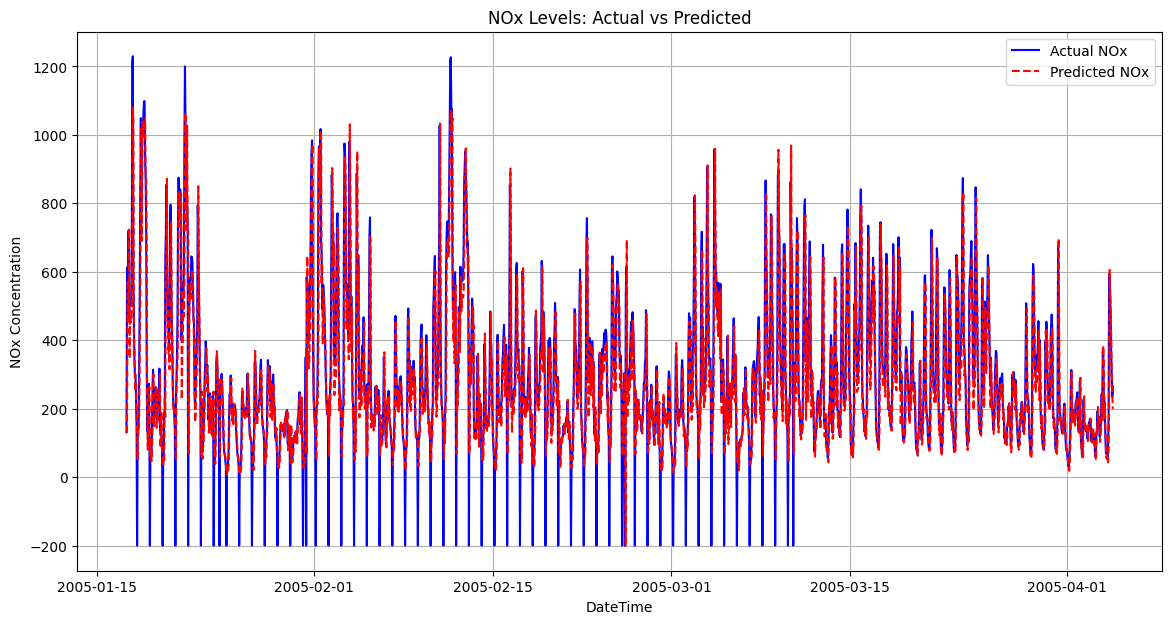

In [41]:
# Your code here (5 points)
input_dim = 1
hidden_dim = 2
output_dim = 1
num_layers = 4
sequence_length = 3
learning_rate = 0.01
num_epochs = 50
batch_size = 20
# Your code here
model = RNNRegressor(input_dim, hidden_dim, output_dim, num_layers, sequence_length,learning_rate, num_epochs, batch_size)
model.fit(X_train_scaled, y_train_scaled)

# Predicting the NOx level for the test set
y_pred = scaler.inverse_transform(model.predict(X_test_scaled))

# Calculating the MSE on the test set
mse = mean_squared_error(y_test, y_pred)

print("The mean squared error of the model is:\t",mse)

visualize(y_test, y_pred, test_datetime)

**Your discussion here (5 points)**
1. Increasing the number of hidden dimension from 1 to 2 allowed the model to learn more complex patterns in the data, enabling the model to store more information about past inputs in any point in time, leading to better model prediction accuracy.

2. Increase in output dimension makes the model architecture more aligned to get better predictions which are tailored to the expected results

3. Increasing the number of layers to 4 creates a deeper model which can more intricate patterns in the data

4. The sequence length is changed to 3, the model is considering sequence of 3 observations at a time for its predictions. This means model can leverage more contextual information from the data.

5. A suitable learning rate of 0.01 ensures model learns efficiently without overshooting the minimum of the loss function.

**Part 1.3.3.2 (5 points)**: Please compare the your predictions across the 3 models (auto-regressive model, RNN model trained on unscaled data, RNN model trained on scaled data).

**Your discussion here**

1) The performance of the models drastically improves as we move from the first plot to the third plot. The first plot is a simple model that seems to predict a constant value throughout the entire period. It does not seem to have learned the variations in the data and significantly deviates away from actual concentrations

2) The second model captures some of the peaks and troughs but is off in terms of the magnitude. It is definitely an improvement from the first model, but still it is not accurate. The third model is a better trained model that is able to capture the trends and seasonality in the data compared to the first two

3) We can observe from the MSE values that model 3 has the lowest value while model 1 has the highest value

4) The spikes in NOx levels can be attributed to increased traffic or industrial activity, which is captured better in model 3 compared to other models

5) The accuracy of such model is important as it would help decision makers take timely decisions with respect air quality and environment impact, mitigating overall health hazards to the citizens.

### **Part 2 (25 points)**: Image Classification

##### Load CIFAR-10 Data

CIFAR-10 is a dataset consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. The classes include airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. CIFAR-10 is widely used for machine learning and computer vision research and applications, serving as a benchmark for evaluating image recognition algorithms.

In [73]:
from hw3_utils import load_and_preprocess_cifar10

# Load and preprocess the CIFAR-10 dataset
X_train, y_train, X_test, y_test = load_and_preprocess_cifar10()

Files already downloaded and verified
Files already downloaded and verified


##### Visualization

You may use the following `visualize_cifar10` to explore the dataset:

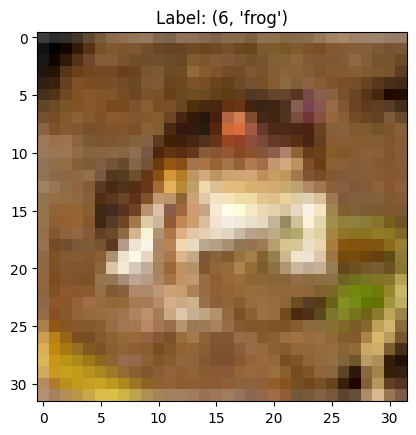

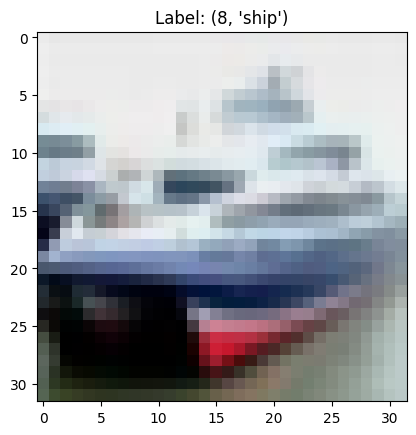

In [74]:
def visualize_cifar10(X, y, index):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
    plt.imshow((X[index].transpose(1, 2, 0) + 1.0) / 2.0)
    plt.title(f'Label: {y[index], labels[y[index]]}')
    plt.show()

visualize_cifar10(X_train, y_train, 0)
visualize_cifar10(X_test, y_test, 1)

**Part 2.1.1 (10 points)** Please finish the `SimpleCNN` class by filling in the appropriate values/variables in the `...` fields.

In [75]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similar to **Part 1**, the class `CNNClassifier` has been implemented for you.

You can initiate an `CNNClassifier` with the following arguments:
- `model`: Instance of the CNN model it wraps. You should use initialize `SimpleCNN` you implemented in the previous part and use the instance.
- `learning_rate`: Controls the size of the steps the optimizer takes while searching for the model's minimum loss. A smaller learning rate means the model will adjust its weights more gradually during training.
- `num_epochs`: The number of times the entire dataset will be passed forward and backward through the CNN. This parameter defines the length of the training process.
- `batch_size`: The number of samples that will be propagated through the network in one forward/backward pass. It defines how many examples you look at before making a weight update.

**Part 2.1.2 (10 points)**: Please use `CNNClassifier` to fit the training data. Please report the accuracy score on the test set. Save your `SimpleCNN` instance to `model`.

In [78]:
from hw3_utils import CNNClassifier
from sklearn.metrics import accuracy_score

# Your code here
model = SimpleCNN()
cnn_model = CNNClassifier(model=model,learning_rate=0.001,num_epochs=10,batch_size=64)

cnn_model.fit(X_train, y_train)

# Predicting the NOx level for the test set
y_pred = cnn_model.predict(X_test)

final_accuracy = accuracy_score(y_test,y_pred)
print("Model accuracy on the test set\t",final_accuracy)

Epoch 10: 100%|██████████| 782/782 [00:37<00:00, 21.12batch/s, loss=0.177]


Model accuracy on the test set	 0.6974


**Part 2.2 (5 points)**: Code in the following cell visualizes the first channels of kernels in the 2 convolutional layers. Please briefly describe what you see. Can you see any difference between the first-layer kernels and the second-layer kernels?

Kernels of the first convolutional layer, first channel:


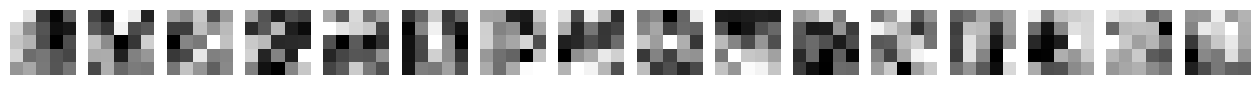

Kernels of the second convolutional layer, first channel:


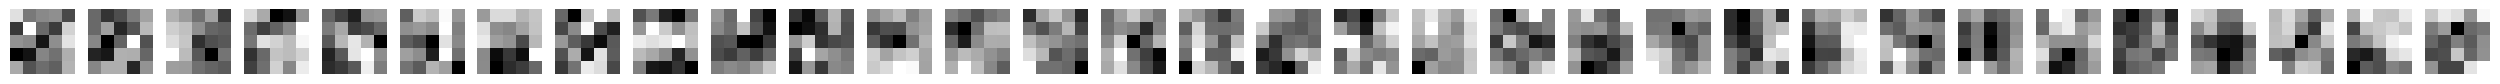

In [79]:
def visualize_kernels(kernels):
    # Normalize the kernels to [0, 1] for visualization
    kernels_min = kernels.min()
    kernels_max = kernels.max()
    kernels = (kernels - kernels_min) / (kernels_max - kernels_min)

    num_kernels = kernels.shape[0]  # Number of kernels in conv1

    # Create a grid for plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_kernels, figsize=(num_kernels, 1))

    for i, ax in enumerate(axs.flat):
        ax.imshow(kernels[i, 0], cmap='gray')
        ax.axis('off')

    plt.show()

print('Kernels of the first convolutional layer, first channel:')
visualize_kernels(model.conv1.weight.data.cpu().numpy())
print('Kernels of the second convolutional layer, first channel:')
visualize_kernels(model.conv2.weight.data.cpu().numpy())

**Your discussion here**

1. The first layer kernels detect simple, low level features such as edges, corners and colors from the input images.

2. The second layer kernel detects more complex and abstract features.

3. They build up on the features generated from the first layer to generate more domain specific features.

4. This is indicated by the difference in the size and complexity of the patterns between the two kernels and points to the hierarchical nature of generating features as observed in point 3

5. The first kernel is larger in size and covers a large part of the input image compared to the second.

5. The


### **Part 3 (20 points)**: Decision Trees

##### Load Data

The `fetch_covtype` method in `sklearn.datasets` loads the forest cover type dataset, which is a classic dataset used for classification tasks. This dataset contains cartographic variables for 30 x 30 meter cells obtained from the US Forest Service (USFS) Region 2 Resource Information System (RIS) data. It includes 581,012 instances and 54 features, predicting forest cover type from cartographic variables. The seven cover types are the labels to predict.

In [68]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

# Fetch the dataset
covtype = fetch_covtype()
X = covtype.data
y = covtype.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Shape of training input: {X_train.shape}, training output: {y_train.shape}')
print(f'Shape of test input: {X_test.shape}, test output: {y_test.shape}')

Shape of training input: (406708, 54), training output: (406708,)
Shape of test input: (174304, 54), test output: (174304,)


**Part 3.1 (5 points)**: Use `DecisionTreeClassifier` with the following hyperparameters to fit the training set:
- `max_depth=100`
- `min_samples_split=2`
- `min_samples_leaf=1`

Please report the accuracy scores on the training set **and** the test set. What do you notice about the accuracy scores?

In [69]:
from sklearn.tree import DecisionTreeClassifier


# Train a default decision tree classifier
default_tree = DecisionTreeClassifier(max_depth=100,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      random_state=42)
default_tree.fit(X_train, y_train)

print(f"Default Decision Tree Train Accuracy: {default_tree.score(X_train, y_train):.3f}")
print(f"Default Decision Tree Test Accuracy: {default_tree.score(X_test, y_test):.3f}")

Default Decision Tree Train Accuracy: 1.000
Default Decision Tree Test Accuracy: 0.934


**Your answer here**

1. Based on the training accuracy, we can see that the model has overfit the training data and has not learned the underlying variations

2. The overfitting that we see negatively affects the model's ability to generalize to new test sets.

3. While the test accuracy is lower than the training accuracy, it is fairly high at 93.4%, which is impressive

4. To address the overfitting, we can adopt various measures such as pruning the tree, or collecting more data

5. Cross validation would help us understand the performance of the model accurately across various folds of data

**Part 3.2 (15 points)**: Please use grid search to find the best set of hyperparameters for `DecisionTreeClassifier` that maximizes test set accuracy from the following grid:
```
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
```

Report the accuracy scores on the training set **and** the test set using the **best** set of hyperparameters. Please also report the best set of hyperparameters. Compare the accuracy scores and the best set of hyperparameters with the previous part.

In [70]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Extract the best parameters and model
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

# Evaluate the optimized classifier
print(f"Optimized Decision Tree Train Accuracy: {best_tree.score(X_train, y_train):.3f}")
print(f"Optimized Decision Tree Test Accuracy: {best_tree.score(X_test, y_test):.3f}")

# Print best parameters
print(f"Best Parameters: {best_params}")

Optimized Decision Tree Train Accuracy: 0.999
Optimized Decision Tree Test Accuracy: 0.940
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Your answer here (5 points)**

1. The training accuracy for the optimized model is slightly lower (0.999) compared to the non optimized model (1.000). While it is slightly lower, the optimized model is still overfitting the data

2. The test accuracy has improved in the optimized model which indicates that the model is in a better position to generalize to new test data

3. The information criterion was changed to entropy from the gini default to generate better splits on the data

4. Min_samples_split and min_samples_leaf remained the same in the optimized hyperparameter configuration indicating that the model prefers very small splits and single sample leaves respectively

5. The max depth was set to 30 to identify a balance between a shallow tree vs a deep true, to allow for better generalizing ability to new test data.